# Navier Stokes in a pipe flow (stationary 2D) with hard constraints + Metamodel learning + HyperPINN

We solve the stationary Navier Stokes PDE:

$$
\begin{cases}
\nabla\cdot\mathbf{u}=0,\\
(\mathbf{u}\cdot\nabla)\mathbf{u} + \frac{1}{\rho}\nabla p - \theta \nabla^2\mathbf{u}=0.
\end{cases}
$$

This becomes in 2D, with $\mathbf{u}=\begin{pmatrix}u_x \\ u_y\end{pmatrix}$


$$
\begin{cases}
\frac{\partial}{\partial x} u_x + \frac{\partial}{\partial y} u_y = 0 \\
\begin{pmatrix}u_x\frac{\partial}{\partial x} u_x + u_y\frac{\partial}{\partial y} u_x \\
u_x\frac{\partial}{\partial x} u_y + u_y\frac{\partial}{\partial y} u_y  \end{pmatrix} +
\frac{1}{\rho} \begin{pmatrix} \frac{\partial}{\partial x} p \\ \frac{\partial}{\partial y} p \end{pmatrix}
- \theta
\begin{pmatrix}
\frac{\partial^2}{\partial x^2} u_x + \frac{\partial^2}{\partial y^2} u_x \\
\frac{\partial^2}{\partial x^2} u_y + \frac{\partial^2}{\partial y^2} u_y
\end{pmatrix} = 0\\
\end{cases}
$$


With the boundary condition:
$$
\begin{cases}
u(x, \frac{d}{2}) = -u(x, \frac{d}{2})=0, \forall x \text{ (boundary condition) }\\
p(x_{min}, y)=0 \text{ and } p(x_{max}, y)=0.1, \forall y \text{ (boundary condition) }
\end{cases}
$$

The domain is defined with $x\in[0,L]$ and $y\in[-R, R]$. __Note__ that because of the central symmetry with respect to the centerline of the tube, we only consider the $y$ axis which will represent the cross section

This notebook aims at reproducing the example of section 3.1 of [*Surrogate modeling for fluid flows based on physics-constrained deep learning without simulation data*, Sun et al. 2020](https://www.sciencedirect.com/science/article/pii/S004578251930622X), __including the introduction of a *metamodel*, i.e., a parameter from the equation $\theta$, is itself input of the neural network and we learn a solution $\forall \theta$.__

__We also compare the metamodeling using an HyperPINN [*HyperPINN: Learning parameterized differential equations with physics-informed hypernetworks](https://arxiv.org/pdf/2111.01008.pdf)__

## 1 )Metamodeling with a classical PINN

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
# import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
# import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [3]:
import jinns

Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import matplotlib.pyplot as plt

key = random.PRNGKey(2)

Create a DataGenerator object and set up some geometry. Following the [authors' implementation](https://github.com/Jianxun-Wang/LabelFree-DNN-Surrogate/blob/master/Tutorial/PipeFlow.ipynb), we set a pipe length $L=1$ and a pipe radius$R=0.05$. Following the authors, we also simplify the problem because of its geometry: the solution is symmetric with respect to the center of the pipe, at a given point $x\in[0, L]$. Therefore we only need one axis representing a pipe cross section and one axis representing the pipe length.

In [5]:
L = 1
R = 0.05

p_out = 0
p_in = 0.1

In [6]:
n = 1000
nb = None
omega_batch_size = 128
omega_border_batch_size = None
dim = 2
xmin = 0
xmax = xmin + L
ymin = -R
ymax = ymin + 2 * R
# zmin = -R
# zmax = zmin + 2 * R



__Note:__ that we choose a very simple data generator and no boundary condition despite the pipe-like geometry. Indeed, we choose to follow the author's hard coded boundary constraints. The neural network outputs are then multiplied with a factor which enforces the constraints. We impose the so-called _slip-condition_ on the borders, ie, the fluid has a null speed on the borders.

Create the neural network architecture for the PINN with `equinox`. We have two Pinns for the velocity field `u` and for the pressure field `p`. The first one is vectorial (2D) the second one is scalar.

In [7]:
eqx_list = [
    [eqx.nn.Linear, 3, 50],
    [jax.nn.swish],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.swish],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.swish],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.swish],
    [eqx.nn.Linear, 50, 3],
]
key, subkey = random.split(key)
def output_transform(pinn_in, pinn_out):
    u = pinn_out[:2] * (R**2 - pinn_in[1] ** 2)
    p = (
         (pinn_in[0] - xmin) / (xmax - xmin) * p_out
         + (xmax - pinn_in[0]) / (xmax - xmin) * p_in
         + (xmin - pinn_in[0]) * (xmax - pinn_in[0]) * pinn_out[2:3]
     )
    return jnp.concatenate([u, p], axis=-1)

def input_transform(x, params):
    return jnp.concatenate([x, params["eq_params"]["nu"]], axis=-1)
    
u, p = jinns.utils.create_PINN(
    subkey,
    eqx_list,
    "statio_PDE",
    2,
    input_transform=input_transform,
    output_transform=output_transform,
    shared_pinn_outputs=(jnp.s_[:2], jnp.s_[2])
)

Recall that the `u` and `p` network are the same by design, so we must use the same parameters!

In [8]:
u_init_nn_params = u.init_params()
p_init_nn_params = u_init_nn_params

Plot the initial PINN outputs

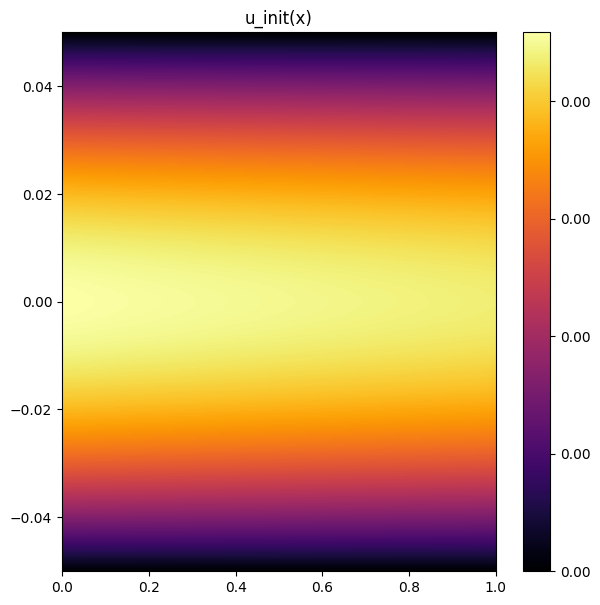

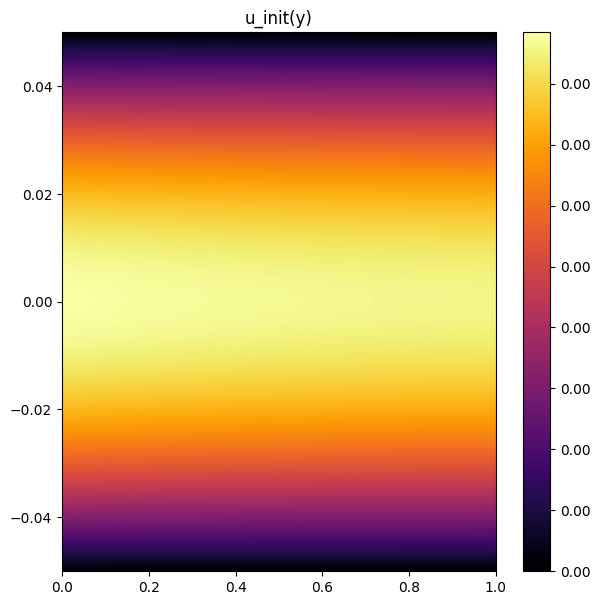

In [9]:
nx, ny = 1000, 1000
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]

u_xinit = lambda x: u(x, {"nn_params":u_init_nn_params, "eq_params":{"rho":1., "nu":jnp.array([0.0004])}})[0]
jinns.data.plot2d(
    fun=u_xinit,
    xy_data=val_xy_data,
    title="u_init(x)"
)

u_yinit = lambda x: u(x, {"nn_params":u_init_nn_params, "eq_params":{"rho":1., "nu":jnp.array([0.0004])}})[1]
jinns.data.plot2d(
    fun=u_yinit,
    xy_data=val_xy_data,
    title="u_init(y)"
)

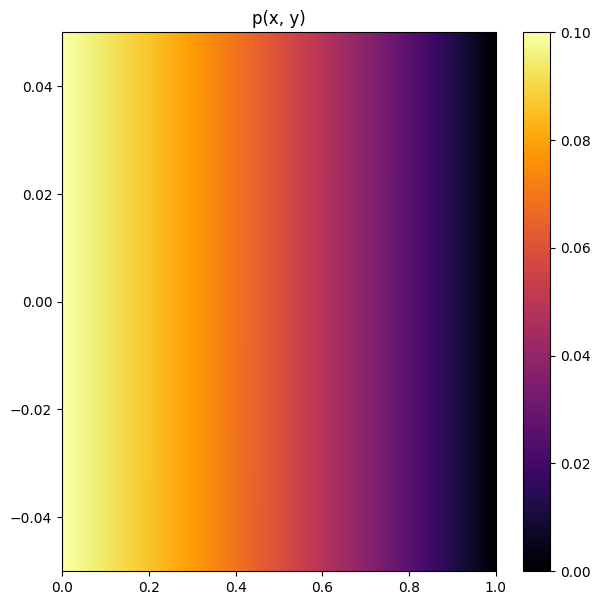

In [10]:
jinns.data.plot2d(
    fun = lambda x: p(x, {"nn_params":u_init_nn_params, "eq_params":{"rho":1., "nu":jnp.array([0.0004])}}),
    xy_data=val_xy_data,
    title = "p(x, y)"
)

Data generator creation

In [11]:
method = "uniform"
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDEStatio(
    subkey,
    n,
    nb,
    omega_batch_size,
    omega_border_batch_size,
    dim,
    (xmin, ymin),
    (xmax, ymax),
    method
)

Here we create another data generator for the equation parameter $\theta$. The class is simple to use but we require that the batch size for such generator be the same of the other generator !

In [12]:
method = "grid"
key, subkey = random.split(key)
np = 1000
param_batch_size = 128 # must be equal to batch size of the main DataGenerator
param_train_data = jinns.data.DataGeneratorParameter(
    subkey,
    np,
    param_batch_size,
    {'nu':(2e-4, 1.9e-3)},
    method,
)

## Model parameters

Here we set the density $\rho=1$ and we simplify the problem with respect to the article: $\theta$ is the viscosity parameter, __it is not fixed here but a solution is learnt $\forall \theta$ in a given interval__.

In [13]:
rho = 1.
# nu = 0.00061

Delta_p = 0.1
d = 2 * R

A set of parameters as required by the losses' `evaluate`. Here we adapt to the particular dynamic loss which requires the keys `u` and `p`.

In [14]:
# initiate parameters dictionary
init_params = {}
init_params['nn_params'] = {
    "u": u_init_nn_params,
    "p": u_init_nn_params
}
init_params["eq_params"] = {"rho":rho, **param_train_data.get_batch()} # NOTE the additional batch is a dict 

## Analytical solution
In this case, the analytical solution is known:
$$
u_a = \frac{\Delta p}{2\theta\rho L}(\frac{d^2}{4} - y^2)
$$

Text(0.5, 1.0, 'True solution along a cross section')

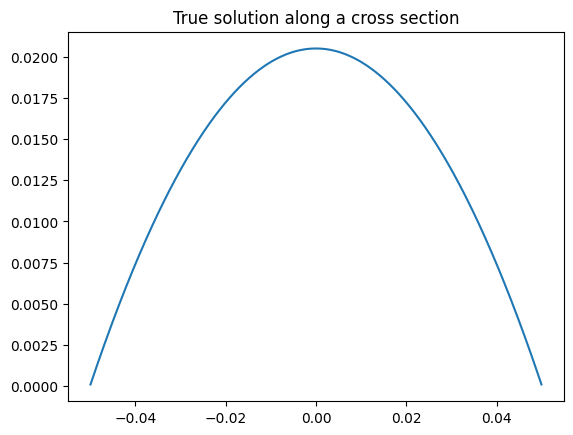

In [15]:
def u_true(y, nu=0.0061):
    return Delta_p / (2 * nu * rho * L) * ((d / 2) ** 2 - y ** 2)

plt.plot(train_data.omega[:, 1].sort(axis=0), vmap(u_true, (0), 0)(train_data.omega[:, 1].sort(axis=0)))
plt.title(r"True solution along a cross section")

## Loss construction

In [16]:
mc_loss = jinns.loss.MassConservation2DStatio(nn_key='u')
ns_loss = jinns.loss.NavierStokes2DStatio(u_key='u', p_key='p')

In [17]:
loss_weights = {"dyn_loss":1.}
    
loss = jinns.loss.SystemLossPDE(
    u_dict={'u':u, 'p':p},
    loss_weights=loss_weights,
    dynamic_loss_dict={'mass_conservation':mc_loss, 'navier_stokes':ns_loss},
    nn_type_dict={'u':'nn_statio', 'p':'nn_statio'}
)

/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_LossPDE.py:372: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


Note that we need to concatenate the two batches from the two data generator, this is particular for this metamodel learning procedure. However, this procedure will be transparent in the rest of the code.

In [18]:
from jinns.data import append_param_batch
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    batch = append_param_batch(train_data.get_batch(), param_train_data.get_batch())
)


l_tot, dict_losses = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in dict_losses.items()} }")

total loss: 0.01
Individual losses: {'boundary_loss': '0.00', 'dyn_loss': '0.01', 'norm_loss': '0.00', 'observations': '0.00', 'sobolev': '0.00'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [19]:
params = init_params

In [20]:
# Optimizer
import optax

tx = optax.radam(learning_rate=1e-3)

In [21]:
n_iter = 20000

In [22]:
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    param_data=param_train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter
)

/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_LossPDE.py:372: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


Iteration 0: loss value = 0.009719505906105042


  0%|          | 0/20000 [00:00<?, ?it/s]

Iteration 1000: loss value = 0.0016942562069743872
Iteration 2000: loss value = 0.0018287472194060683
Iteration 3000: loss value = 0.002126543316990137
Iteration 4000: loss value = 0.0015236197505146265
Iteration 5000: loss value = 0.0018549642991274595
Iteration 6000: loss value = 0.0005806948756799102
Iteration 7000: loss value = 0.0005295122391544282
Iteration 8000: loss value = 0.0004802892217412591
Iteration 9000: loss value = 0.00039914841181598604
Iteration 10000: loss value = 0.0003999006294179708
Iteration 11000: loss value = 0.0003725408168975264
Iteration 12000: loss value = 0.00026214218814857304
Iteration 13000: loss value = 0.00013670868065673858
Iteration 14000: loss value = 0.00014477041258942336
Iteration 15000: loss value = 0.0001700064167380333
Iteration 16000: loss value = 6.436849071178585e-05
Iteration 17000: loss value = 0.00010410890536149964
Iteration 18000: loss value = 4.520795846474357e-05
Iteration 19000: loss value = 4.5758461055811495e-05
Iteration 20000:

## Results

Plot the loss values

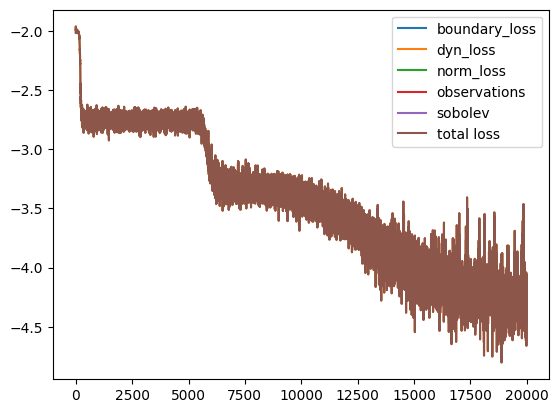

In [23]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

Plot the ODE solutions learned by the PINN. Note that we need to fix $\theta$ to certain values.

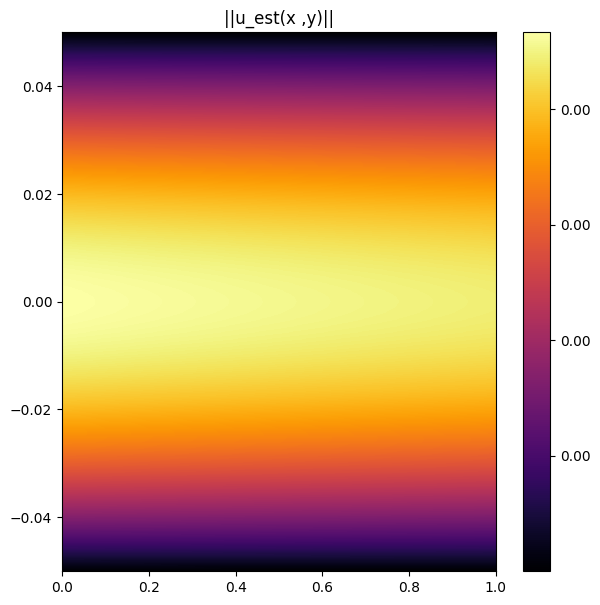

In [24]:
jinns.data.plot2d(
    fun = lambda x: jnp.linalg.norm(u(x, {"nn_params":u_init_nn_params, "eq_params":{"rho":1., "nu":jnp.array([0.0004])}})),#[0],
    xy_data = val_xy_data,
    title="||u_est(x ,y)||"
)

# jinns.data.plot2d(
#     fun = lambda x: jnp.linalg.norm(u(x, {"nn_params":u_init_nn_params, "eq_params":{"rho":1., "nu":jnp.array([0.0004])}})),#[0],
#     xy_data = val_xy_data,
#     title="u_est, x(x ,y)"
# )

We now plot some slices for fixed $\theta$ along with the true solution.

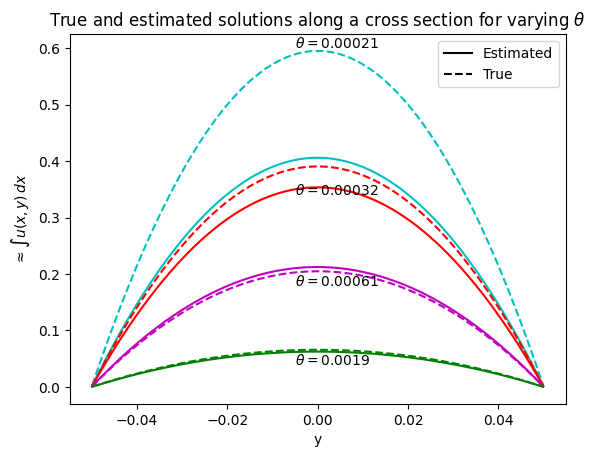

In [25]:
v_u_est_y_nu = lambda x, y_j, nu:vmap(
    # compute average over array x with y_j fixed.
    lambda x, y_j: vmap(lambda z: u(jnp.stack([z, y_j], axis=-1), 
                                    {"nn_params":params["nn_params"]["u"], "eq_params":{"rho":rho, "nu":jnp.array([nu])}})[0],
                        0, 0)(x).mean(), 
    (None, 0), 
    0)(x, y_j)

for nu, c in zip([0.00021, 0.00032, 0.00061, 0.0019], ['c', 'r', 'm', 'g']):
    plt.plot(
        train_data.omega[:, 1].sort(axis=0),
        v_u_est_y_nu(
            train_data.omega[:, 0].sort(axis=0),
            train_data.omega[:, 1].sort(axis=0),
            nu),
        c
    )

    plt.plot(train_data.omega[:, 1].sort(axis=0),
             vmap(lambda x: u_true(x, nu=nu), (0), 0)(train_data.omega[:, 1].sort(axis=0)),
             c + '--'
    )

plt.xlabel("y")
plt.ylabel(r"$\approx \int u(x, y) \, dx$")
line1, = plt.plot([0], "k", label='Estimated')
line2, = plt.plot([0], "k--", label='True')
plt.text(-0.005, 0.6, r"$\theta=0.00021$")
plt.text(-0.005, 0.34, r"$\theta=0.00032$")
plt.text(-0.005, 0.18, r"$\theta=0.00061$")
plt.text(-0.005, 0.04, r"$\theta=0.0019$")
plt.legend(handles=[line1,line2])
plt.title(r"True and estimated solutions along a cross section for varying $\theta$")
plt.show()

## 2) Metamodeling with an HyperPINN

We solve the same problem with an HyperPINN as provided by **jinns** and compare the two approaches

In [26]:
eqx_list = [
    [eqx.nn.Linear, 2, 16],
    [jax.nn.swish],
    [eqx.nn.Linear, 16, 16],
    [jax.nn.swish],
    [eqx.nn.Linear, 16, 16],
    [jax.nn.swish],
    [eqx.nn.Linear, 16, 16],
    [jax.nn.swish],
    [eqx.nn.Linear, 16, 16],
    [jax.nn.swish],
    [eqx.nn.Linear, 16, 16],
    [jax.nn.swish],
    [eqx.nn.Linear, 16, 16],
    [jax.nn.swish],
    [eqx.nn.Linear, 16, 3],
]

eqx_list_hyper = [
    [eqx.nn.Linear, 1, 32], # input is of size 1 for scalar viscosity nu
    [jax.nn.tanh],
    [eqx.nn.Linear, 32, 32],
    [jax.nn.tanh],
    [eqx.nn.Linear, 32, 32],
    [jax.nn.tanh],
    [eqx.nn.Linear, 32, 16],
    [jax.nn.tanh],
    [eqx.nn.Linear, 16, 1000], # 1000 is a random guess, it will automatically be filled with the correct value
]

def output_transform(pinn_in, pinn_out):
    u = pinn_out[:2] * (R**2 - pinn_in[1] ** 2)
    p = (
         (pinn_in[0] - xmin) / (xmax - xmin) * p_out
         + (xmax - pinn_in[0]) / (xmax - xmin) * p_in
         + (xmin - pinn_in[0]) * (xmax - pinn_in[0]) * pinn_out[2:3]
     )
    return jnp.concatenate([u, p], axis=-1)

    
key, subkey = random.split(key)
hyperparams = ["nu"]
hypernet_input_size = 1
dim_x = 2
u_hyper, p_hyper = jinns.utils.create_HYPERPINN(
    subkey, eqx_list, "statio_PDE",
    hyperparams, hypernet_input_size,
    dim_x, eqx_list_hyper=eqx_list_hyper,
    output_transform=output_transform,
    shared_pinn_outputs=(jnp.s_[:2], jnp.s_[2])
)

In [27]:
u_init_nn_params = u_hyper.init_params()
p_init_nn_params = u_init_nn_params

In [28]:
# initiate parameters dictionary
init_params_hyper = {}
init_params_hyper['nn_params'] = {
    "u": u_init_nn_params,
    "p": u_init_nn_params
}
init_params_hyper["eq_params"] = {"rho":rho, **param_train_data.get_batch()} # NOTE the additional batch is a dict 

In [29]:
loss_weights = {"dyn_loss":1.}
    
loss_hyper = jinns.loss.SystemLossPDE(
    u_dict={'u':u_hyper, 'p':p_hyper},
    loss_weights=loss_weights,
    dynamic_loss_dict={'mass_conservation':mc_loss, 'navier_stokes':ns_loss},
    nn_type_dict={'u':'nn_statio', 'p':'nn_statio'}
)

In [30]:
params_hyper = init_params_hyper

In [31]:
# Optimizer
import optax
tx = optax.radam(learning_rate=1e-3)

In [32]:
n_iter = 20000
params_hyper, total_loss_list_hyper, loss_by_term_dict_hyper, train_data, loss_hyper, _, _ = jinns.solve(
    init_params=params_hyper,
    data=train_data,
    param_data=param_train_data,
    optimizer=tx,
    loss=loss_hyper,
    n_iter=n_iter
)

/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_LossPDE.py:372: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


  0%|          | 0/20000 [00:00<?, ?it/s]

Iteration 0: loss value = 0.03714238479733467
Iteration 1000: loss value = 0.001712919445708394
Iteration 2000: loss value = 0.0017345459200441837
Iteration 3000: loss value = 0.001705362694337964
Iteration 4000: loss value = 0.0016570190200582147
Iteration 5000: loss value = 0.0012233330635353923
Iteration 6000: loss value = 0.0001856148155638948
Iteration 7000: loss value = 0.0005769323906861246
Iteration 8000: loss value = 0.0019270430784672499
Iteration 9000: loss value = 0.00026534232893027365
Iteration 10000: loss value = 0.0002490489277988672
Iteration 11000: loss value = 9.79719334281981e-05
Iteration 12000: loss value = 2.8108563128625974e-05
Iteration 13000: loss value = 0.0004887679242528975
Iteration 14000: loss value = 0.0003482334141153842
Iteration 15000: loss value = 0.00021067225316073745
Iteration 16000: loss value = 8.638716826681048e-05
Iteration 17000: loss value = 7.230776827782393e-05
Iteration 18000: loss value = 0.00010041423229267821
Iteration 19000: loss valu

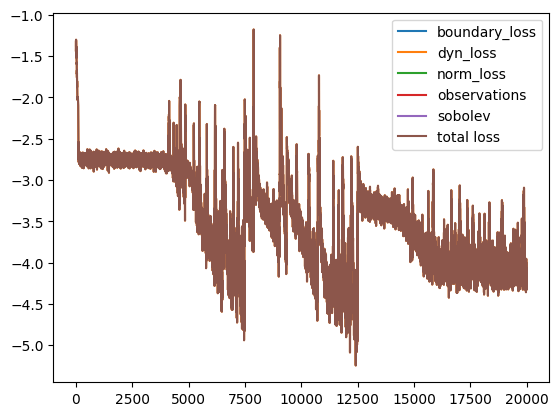

In [33]:
for loss_name, loss_values in loss_by_term_dict_hyper.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_hyper), label="total loss")
plt.legend()
plt.show();

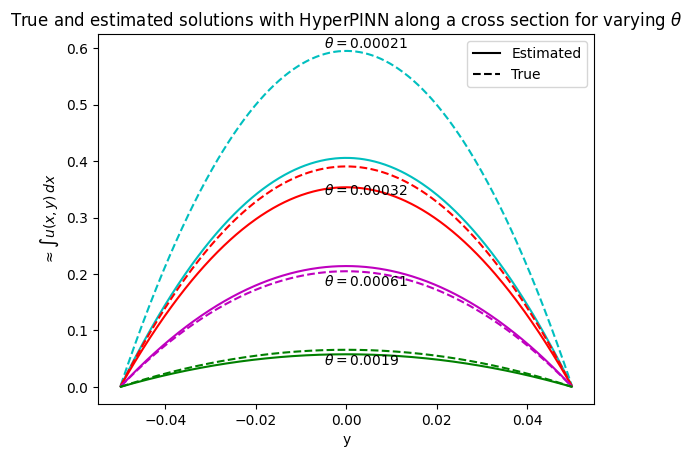

In [34]:
v_u_est_y_nu_hyper = lambda x, y_j, nu:vmap(
    # compute average over array x with y_j fixed.
    lambda x, y_j: vmap(lambda z: u_hyper(jnp.stack([z, y_j], axis=-1), 
                                    {"nn_params":params_hyper["nn_params"]["u"], "eq_params":{"rho":rho, "nu":jnp.array([nu])}})[0],
                        0, 0)(x).mean(), 
    (None, 0), 
    0)(x, y_j)

for nu, c in zip([0.00021, 0.00032, 0.00061, 0.0019], ['c', 'r', 'm', 'g']):
    plt.plot(
        train_data.omega[:, 1].sort(axis=0),
        v_u_est_y_nu_hyper(
            train_data.omega[:, 0].sort(axis=0),
            train_data.omega[:, 1].sort(axis=0),
            nu),
        c
    )

    plt.plot(train_data.omega[:, 1].sort(axis=0),
             vmap(lambda x: u_true(x, nu=nu), (0), 0)(train_data.omega[:, 1].sort(axis=0)),
             c + '--'
    )

plt.xlabel("y")
plt.ylabel(r"$\approx \int u(x, y) \, dx$")
line1, = plt.plot([0], "k", label='Estimated')
line2, = plt.plot([0], "k--", label='True')
plt.text(-0.005, 0.6, r"$\theta=0.00021$")
plt.text(-0.005, 0.34, r"$\theta=0.00032$")
plt.text(-0.005, 0.18, r"$\theta=0.00061$")
plt.text(-0.005, 0.04, r"$\theta=0.0019$")
plt.legend(handles=[line1,line2])
plt.title(r"True and estimated solutions with HyperPINN along a cross section for varying $\theta$")
plt.show()

## 3) Conclusion

When allocated the same number of iterations:

- Metamodeling with a classical PINN: 20000/20000 [01:06<00:00, 300.70it/s]
- Metamodeling with an HyperPINN: 20000/20000 [02:01<00:00, 164.59it/s]

Both method converged approximately to the same solution. A speed advantage goes to the classical PINN approach. We suppose HyperPINNs might be really advantageous on more complex problems when several parameters are considered as hyperpameters.